In [11]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.inspection import PartialDependenceDisplay


Cargar y limpiar datos

In [3]:
housing = pd.read_csv('housing.csv')
housing = pd.get_dummies(housing, drop_first=True)
housing['total_bedrooms'] = housing['total_bedrooms'].fillna(housing['total_bedrooms'].mean())
target = 'median_house_value'
X = housing.copy().drop(target, axis=1)
y = housing[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [4]:
# Entrenar modelo de gradient boosting trees
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)

# Evaluación
r2_score(y_pred, y_test)

0.66886619271418

In [6]:
## Cross validation 
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('gbt', GradientBoostingRegressor(n_estimators=300))
])

params = {
    'gbt__max_depth': [3, 4, 5, 6], 
    'gbt__learning_rate': [0.01, 0.05, 0.1, 0.5]
}

grid_gbt = GridSearchCV(estimator=pipeline, cv=5, n_jobs=-1, scoring='r2', param_grid=params)

grid_gbt.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('gbt',
                                        GradientBoostingRegressor(n_estimators=300))]),
             n_jobs=-1,
             param_grid={'gbt__learning_rate': [0.01, 0.05, 0.1, 0.5],
                         'gbt__max_depth': [3, 4, 5, 6]},
             scoring='r2')

grid_gbt.best_estimator_.named_steps['gbt']

In [7]:
# Mejor estimador 
best_grid_gbt = grid_gbt.best_estimator_.named_steps['gbt']

In [8]:
# r2 score
predicciones = best_grid_gbt.predict(X_test)
r2_score(y_true=y_test, y_pred=predicciones)

0.8293908367934439

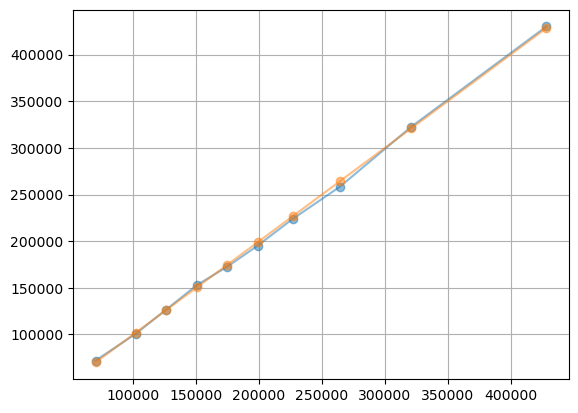

In [9]:
## Calibracion
df_calibrated = pd.DataFrame({
    'predicciones': predicciones,
    'y_true': y_test
})
df_calibrated['bins'] = pd.qcut(df_calibrated['predicciones'], q=10, labels=False) + 1

grouped = df_calibrated.groupby('bins').mean()

plt.plot(grouped.predicciones, grouped.y_true, marker="o", label="Modelo GBT", alpha=0.5)
plt.plot(grouped.predicciones, grouped.predicciones, marker="o", label="Modelo GBT", alpha=0.5)
plt.grid()

In [10]:
# Entendiendo el modelo 
df_importance = pd.DataFrame({
    'features': X_test.keys(),
    'importancia': best_grid_gbt.feature_importances_
})
df_importance.sort_values('importancia')

,features,importancia
9,ocean_proximity_ISLAND,0.000207
10,ocean_proximity_NEAR BAY,0.000920
11,ocean_proximity_NEAR OCEAN,0.008106
6,households,0.015455
3,total_rooms,0.017810
4,total_bedrooms,0.029460
5,population,0.039137
2,housing_median_age,0.046570
1,latitude,0.087856
0,longitude,0.095045


    PartialDependenceDisplay.from_estimator(
        best_grid_gbt,
        X_train,
        [i],
        feature_names=X_train.columns
    )

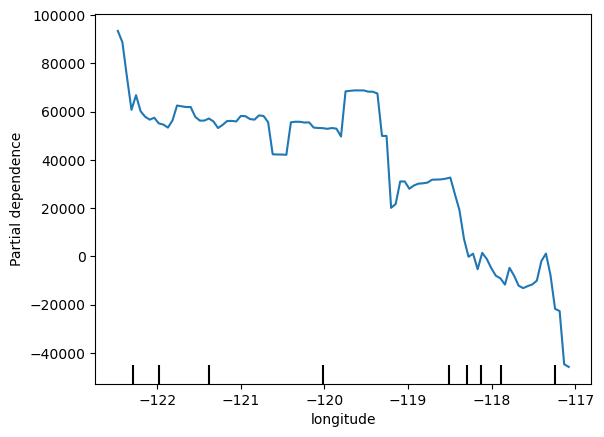

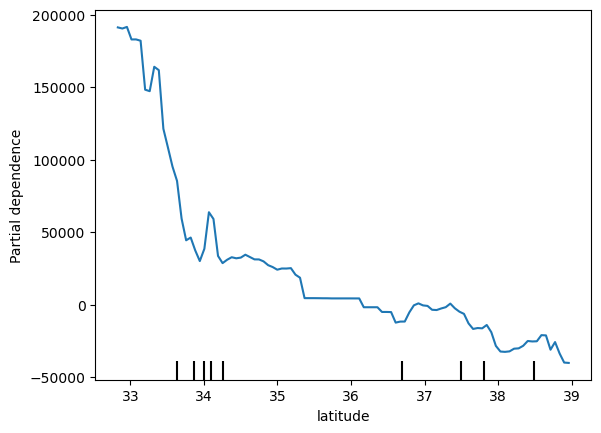

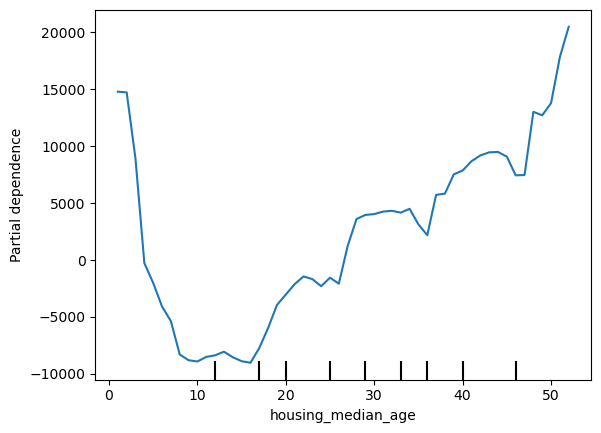

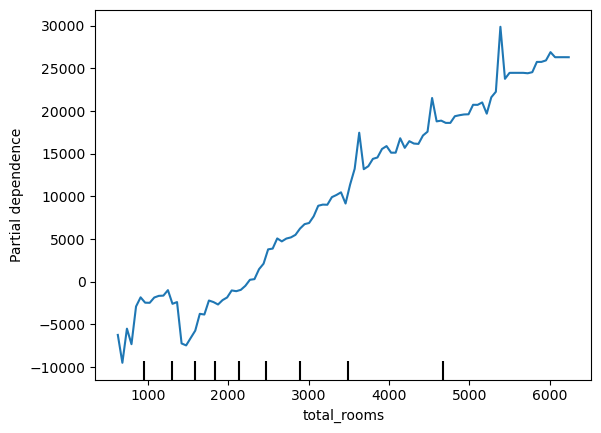

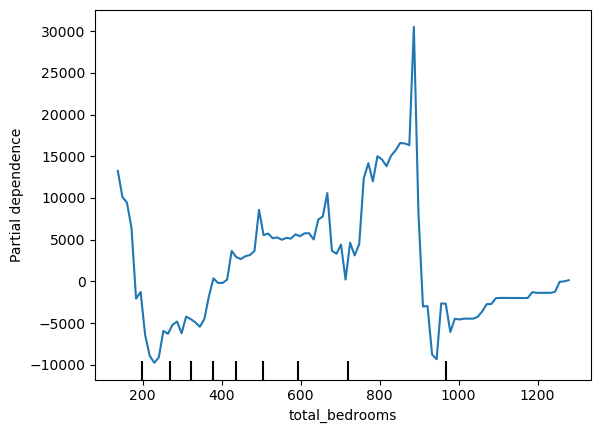

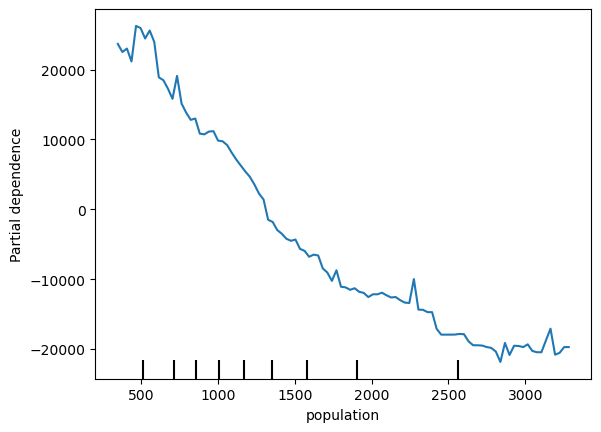

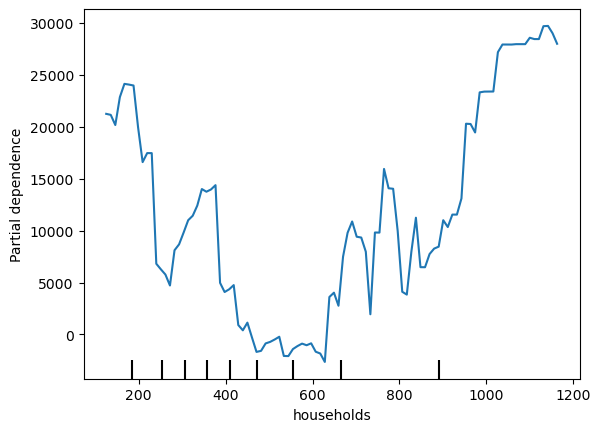

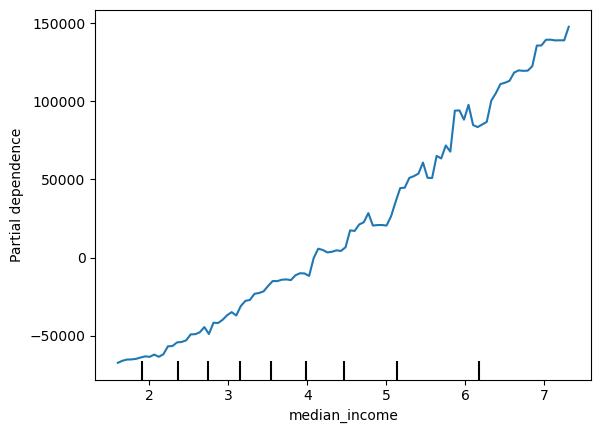

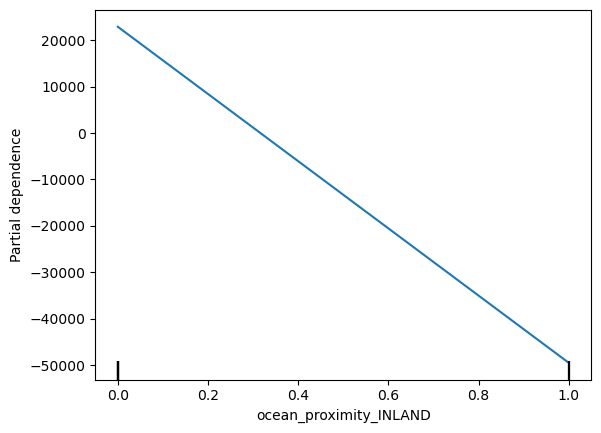

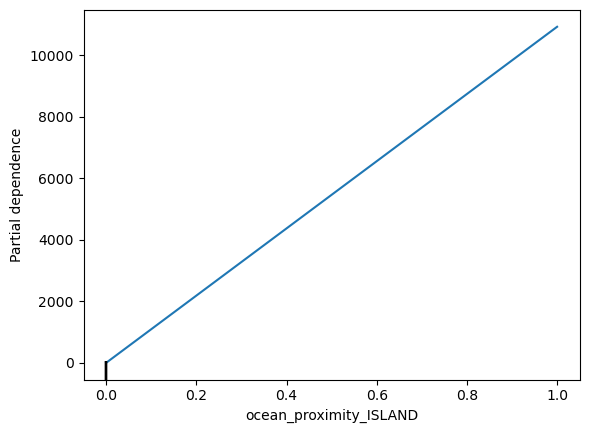

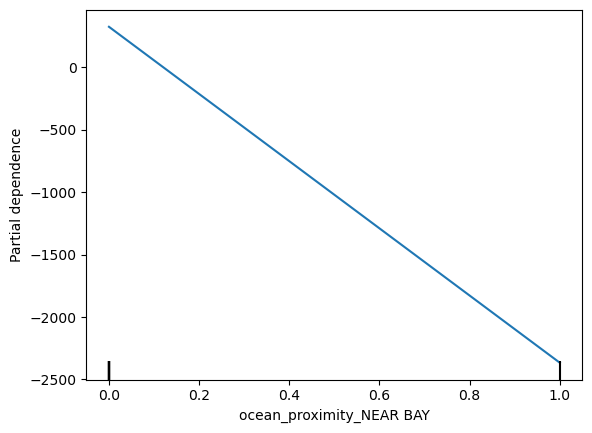

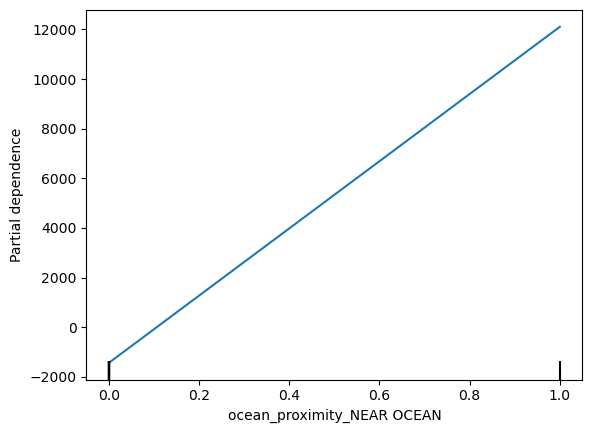

In [66]:
# Codigo for para partial dependence plot 
for i in X_train.keys():
    PartialDependenceDisplay.from_estimator(
        best_grid_gbt,
        X_train,
        [i],
        feature_names=X_train.columns
    )